# Implémentation d'un réseau CNN avec Keras

Dans ce script, nous avons pour objectif de construire un réseau convolutif CNN afin de démontrer les limites de ce type de réseau pour la classification de données frugales.

In [87]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

## Premier réseau CNN

In [77]:
# Définition des hyperparamètres
batch_size = 64
epochs = 10
input_shape = (96, 96, 1)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [78]:
# Definition of the simplified CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Conv2D(128, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),

    Flatten(),
    Dense(1024, activation='relu'),
    # Dropout(0.5),
    Dense(128),
    Dense(10, activation='softmax')
])

model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 10, 10, 128)      

In [55]:
# Custom function to extract category labels from file paths
def extract_category_label(file_path):
    category = os.path.split(os.path.dirname(file_path))[1]  # Extract category from parent directory name
    return category

In [56]:

# Load train, validation, and test data from CSV files
train_df = pd.read_csv('Split_Tanker_Bulk_Container_frugal_vv/train.csv', header=None, names=["file_path"])
validation_df = pd.read_csv('Split_Tanker_Bulk_Container_frugal_vv/validation.csv', header=None, names=["file_path"])
test_df = pd.read_csv('Split_Tanker_Bulk_Container_frugal_vv/test.csv', header=None, names=["file_path"])

# Extract category labels from file paths
train_df['label'] = train_df['file_path'].apply(lambda x: x.split("\\")[0])
validation_df['label'] = validation_df['file_path'].apply(lambda x: x.split("\\")[0])
test_df['label'] = test_df['file_path'].apply(lambda x: x.split("\\")[0])

In [57]:
# Shuffle the data
train_df = shuffle(train_df)
validation_df = shuffle(validation_df)
test_df = shuffle(test_df)

In [58]:
# Show the first few rows of the train data
print(train_df.head())

                                             file_path           label
94   Bulk Carrier\BulkCarrier_Visual_Cargo_x19461_y...    Bulk Carrier
242  Container Ship\ContainerShip_Visual_Cargo_x112...  Container Ship
49   Bulk Carrier\BulkCarrier_Visual_Cargo_x50228_y...    Bulk Carrier
305  Bulk Carrier\BulkCarrier_Visual_Cargo_x10119_y...    Bulk Carrier
114  Bulk Carrier\BulkCarrier_Visual_Cargo_x51229_y...    Bulk Carrier


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Initialize the ImageDataGenerator for basic image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [60]:
image_dir = '../OpenSARShip/Categories/'

# Assuming your CSV files contain columns 'file_path' for the image paths and 'label' for the category labels
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="file_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='sparse')

Found 629 validated image filenames belonging to 3 classes.
Found 211 validated image filenames belonging to 3 classes.
Found 210 validated image filenames belonging to 3 classes.


c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


In [61]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_df.shape[0] // batch_size)

Epoch 1/10
9/9 [==============================] - 25s 2s/step - loss: 1.4263 - accuracy: 0.4425 - val_loss: 0.9451 - val_accuracy: 0.6198
Epoch 2/10
9/9 [==============================] - 15s 1s/step - loss: 0.9551 - accuracy: 0.5593 - val_loss: 0.7420 - val_accuracy: 0.6510
Epoch 3/10
9/9 [==============================] - 15s 1s/step - loss: 0.8600 - accuracy: 0.6000 - val_loss: 0.7607 - val_accuracy: 0.6510
Epoch 4/10
9/9 [==============================] - 15s 1s/step - loss: 0.7914 - accuracy: 0.6301 - val_loss: 0.7373 - val_accuracy: 0.6667
Epoch 5/10
9/9 [==============================] - 15s 1s/step - loss: 0.7346 - accuracy: 0.6655 - val_loss: 0.7191 - val_accuracy: 0.6771
Epoch 6/10
9/9 [==============================] - 15s 1s/step - loss: 0.6829 - accuracy: 0.6979 - val_loss: 0.6653 - val_accuracy: 0.6875
Epoch 7/10
9/9 [==============================] - 15s 1s/step - loss: 0.6222 - accuracy: 0.7469 - val_loss: 0.6307 - val_accuracy: 0.7396
Epoch 8/10
9/9 [==================

In [62]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_df.shape[0] // batch_size)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

3/3 [==============================] - 5s 256ms/step - loss: 0.7966 - accuracy: 0.7135
Test accuracy: 0.7135416865348816, Test loss: 0.7965502738952637


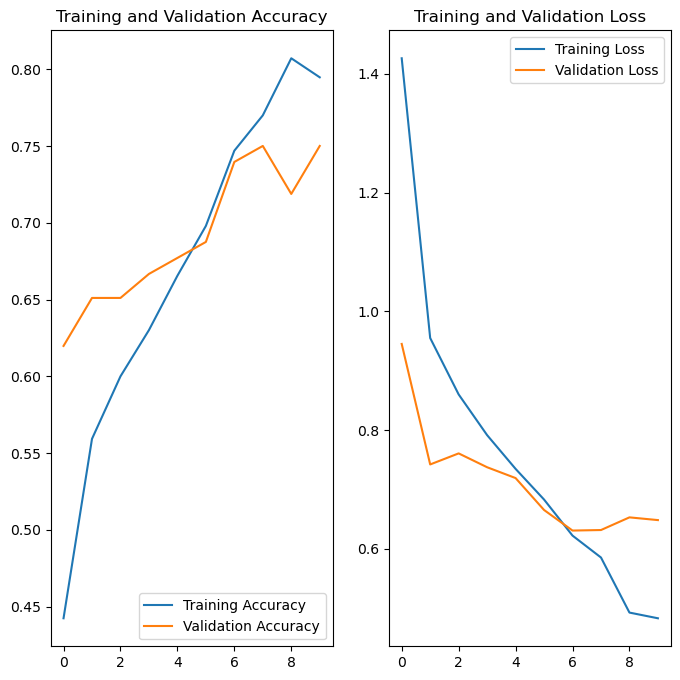

In [63]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


4/4 [==============================] - 6s 163ms/step


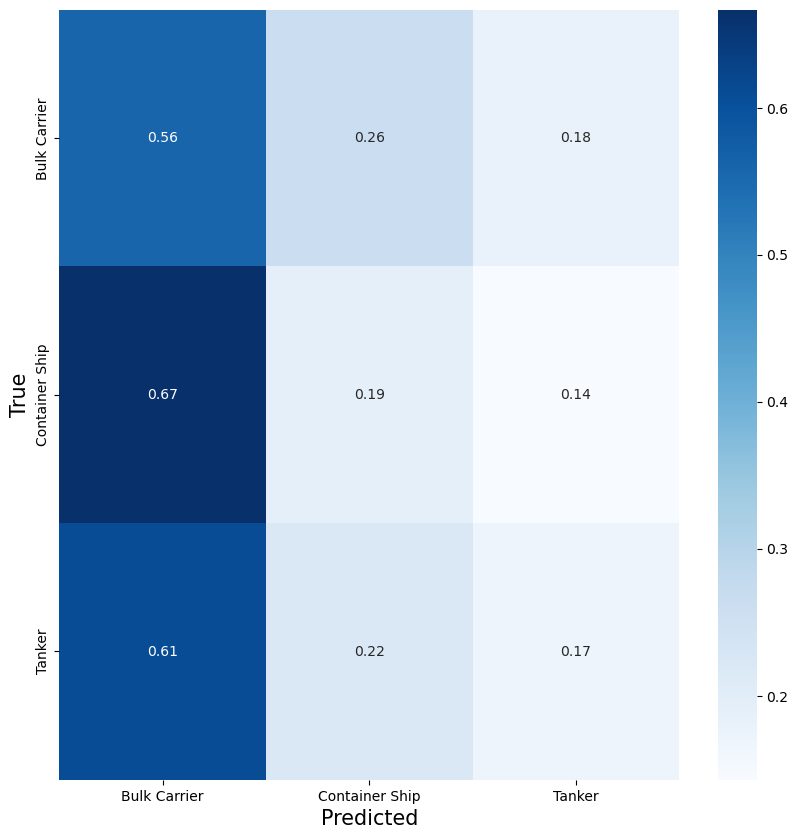

In [64]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted', fontsize=15)
    ax.set_ylabel('True', fontsize=15)
    plt.show()

# Plot the confusion matrix
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(y_true, y_pred, class_names)


## Implementation of CNN class

The aim of this section is to implement a CNN class that will be used to train and test multiple CNN models with various architectures and hyperparameters.

In [79]:
class ModelTrainer:
    
    def __init__(self, model, train_csv, validation_csv, test_csv, image_dir, seed = None):
        self.model = model
        self.train_csv = train_csv
        self.validation_csv = validation_csv
        self.test_csv = test_csv
        self.image_dir = image_dir
        self.seed = seed
        
    def load_data(self):
        if self.seed:
            np.random.seed(self.seed)
        # Load train, validation, and test data from CSV files
        self.train_df = pd.read_csv(self.train_csv, header=None, names=["file_path"])
        self.validation_df = pd.read_csv(self.validation_csv, header=None, names=["file_path"])
        self.test_df = pd.read_csv(self.test_csv, header=None, names=["file_path"])

        # Extract category labels from file paths
        self.train_df['label'] = self.train_df['file_path'].apply(lambda x: x.split("\\")[0])
        self.validation_df['label'] = self.validation_df['file_path'].apply(lambda x: x.split("\\")[0])
        self.test_df['label'] = self.test_df['file_path'].apply(lambda x: x.split("\\")[0])

        # Shuffle the data
        self.train_df = shuffle(self.train_df)
        self.validation_df = shuffle(self.validation_df)
        self.test_df = shuffle(self.test_df)
        
    def compile_model(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss = loss, metrics=metrics)
        
    def train_model(self, batch_size, epochs):
        train_datagen = ImageDataGenerator(rescale=1./255)
        validation_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=self.train_df,
            directory=self.image_dir,
            x_col="file_path",
            y_col="label",
            target_size=(96, 96),
            color_mode="grayscale",
            batch_size=batch_size,
            class_mode='sparse')

        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=self.validation_df,
            directory=self.image_dir,
            x_col="file_path",
            y_col="label",
            target_size=(96, 96),
            color_mode="grayscale",
            batch_size=batch_size,
            class_mode='sparse')

        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=self.train_df.shape[0] // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=self.validation_df.shape[0] // batch_size)
        
    def evaluate_model(self):
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=self.test_df,
            directory=self.image_dir,
            x_col="file_path",
            y_col="label",
            target_size=(96, 96),
            color_mode="grayscale",
            batch_size=batch_size,
            class_mode='sparse')

        test_loss, test_acc = self.model.evaluate(test_generator, steps=self.test_df.shape[0] // batch_size)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
    def plot_training_history(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
        
    def plot_confusion_matrix(self):
        y_pred = self.model.predict(test_generator)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes
        class_names = list(test_generator.class_indices.keys())
        
        cm = confusion_matrix(y_true, y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
        
        plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

In [80]:
def simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [81]:
input_shape = (96, 96, 1)
num_classes = 3
model = simple_cnn(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001)

experiment = ModelTrainer(model, 'Split_Tanker_Bulk_Container_frugal_vv/train.csv', 'Split_Tanker_Bulk_Container_frugal_vv/validation.csv', 'Split_Tanker_Bulk_Container_frugal_vv/test.csv', '../OpenSARShip/Categories/', seed=42)

In [82]:
experiment.load_data()
experiment.compile_model(optimizer, loss, ['accuracy'])
experiment.train_model(batch_size, epochs=10)
experiment.evaluate_model()

Found 629 validated image filenames belonging to 3 classes.
Found 211 validated image filenames belonging to 3 classes.


c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
9/9 [==============================] - 23s 2s/step - loss: 1.0301 - accuracy: 0.5133 - val_loss: 0.8984 - val_accuracy: 0.6354
Epoch 2/10
9/9 [==============================] - 16s 1s/step - loss: 0.9220 - accuracy: 0.5699 - val_loss: 0.7671 - val_accuracy: 0.6719
Epoch 3/10
9/9 [==============================] - 15s 1s/step - loss: 0.8120 - accuracy: 0.6549 - val_loss: 0.7021 - val_accuracy: 0.6979
Epoch 4/10
9/9 [==============================] - 16s 1s/step - loss: 0.7775 - accuracy: 0.6637 - val_loss: 0.6671 - val_accuracy: 0.7135
Epoch 5/10
9/9 [==============================] - 17s 1s/step - loss: 0.6854 - accuracy: 0.7083 - val_loss: 0.7224 - val_accuracy: 0.6458
Epoch 6/10
9/9 [==============================] - 16s 1s/step - loss: 0.6736 - accuracy: 0.7188 - val_loss: 0.6492 - val_accuracy: 0.7760
Epoch 7/10
9/9 [==============================] - 16s 1s/step - loss: 0.5852 - accuracy: 0.7416 - val_loss: 0.6638 - val_accuracy: 0.7344
Epoch 8/10
9/9 [==================

c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


3/3 [==============================] - 4s 235ms/step - loss: 0.7701 - accuracy: 0.7604
Test accuracy: 0.7604166865348816, Test loss: 0.770128071308136


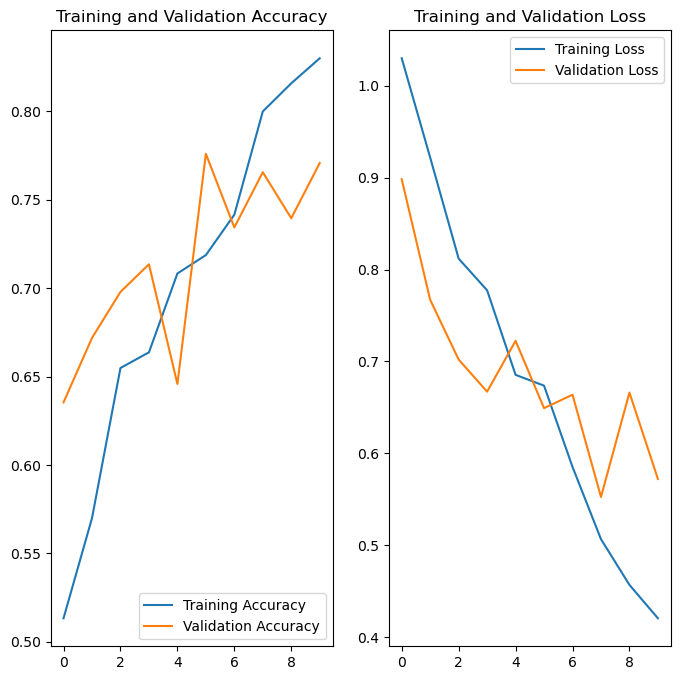

4/4 [==============================] - 6s 178ms/step


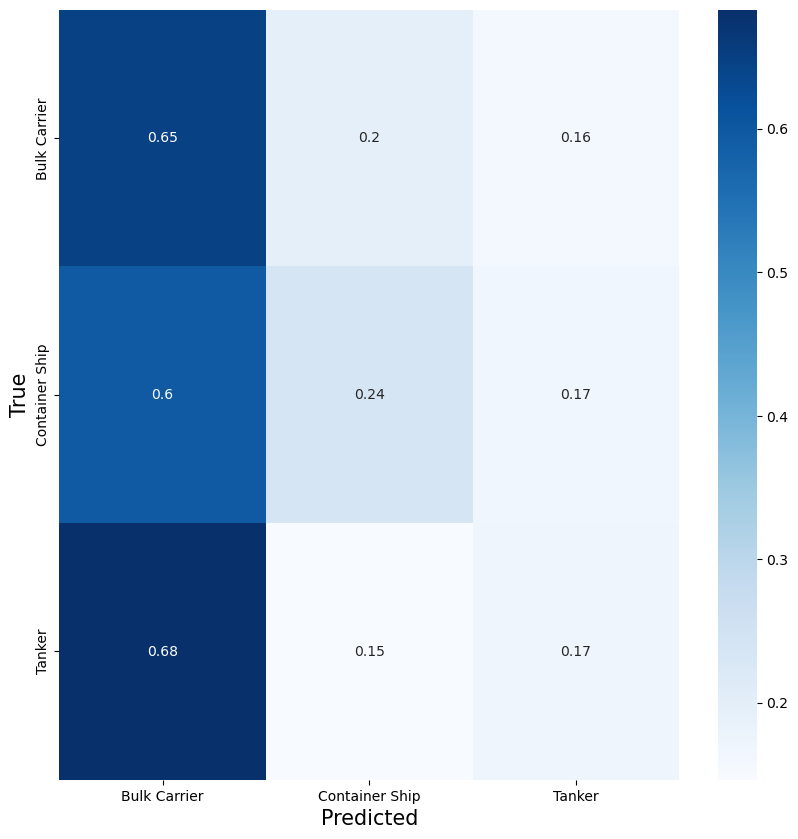

In [83]:
experiment.plot_training_history()
experiment.plot_confusion_matrix()

#